# CONTROLLABILITY

# Preliminaries

In [1]:
!pip -q install tellurium
!pip -q install controlSBML


[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
try:
    import tellurium as te
except:
    !pip -q install tellurium
    import tellurium as te
try:
    import controlSBML as ctl
except:
    !pip install controlSBML
    import controlSBML as ctl

# Controllability basics

Controllability is a property of the open loop system.
It's the ability of the control input, $u(t)$, to affect the measured output $y(t)$.


<img src="https://raw.githubusercontent.com/joseph-hellerstein/advanced-controls-lectures/main/short_class_lectures/images/open_loop_system.png" 
         alt="Types of feature extractiom."
         width="400">

An OLS is controllable if:
1. Increasing $u(t)$ has a monotone effect on $y(t)$ in that either
    * $y(t)$ always increases **OR**
    * $y(t)$ always decreases
1. The *steady state* effect of $u(t)$ on $y(t)$ is approximately linear $$(y(\infty) - y(0)) \approx a (u(\infty) - u(0))$$, where $a$ is a non-zero constant.
1. Transients are short. That is, if $u(t) = u_0$ for $t \leq t_0$ and $u(t) = u_1$ for $t > t_1$,
then $u(t_{ss}) \approx u_1$ for $t_{ss} - t_1$ very small. Specify $t_{ss} - t_1$.

Controllability analysis includes a specification of the operating region:
* Range of values of the measured output for which controllability has been established
* Range of the control input used to obtain the values of measured outputs

# Controllability in the sequential system

In this system, $u(t)$ is $S_1$ and $y(t)$ is $S_3$.

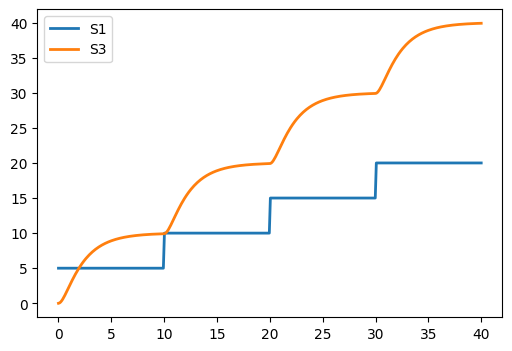

In [3]:
DELTA = 5
SEQUENTIAL_MODEL = f"""
S1 -> S2; k1*(S1 + delta)
S2 -> S3; k2*S2
S3 -> ; k3*S3
k1 = 1
k2 = 2
k3 = 0.5
ref = 5
delta = 0
$S1 = 5
at time>10: S1 = S1 + {DELTA};
at time>20: S1 = S1 + {DELTA};
at time>30: S1 = S1 + {DELTA};
"""
rr = te.loada(SEQUENTIAL_MODEL)
selections = ["time", "S1", "S3"]
rr.simulate(0, 40, 400, selections=selections)
rr.plot()

**Questions: Is the sequential system controllable?**
1. Does increasing $u(t)$ affect $y(t)$ in the same direction?
1. What is the steady state effect of increasing $u(t)$ by 5? Is this consistent for different values of $u(t)$?
2. How long are the transients? Are the duration of transients consistent for different values of $u(t)$?
3. What is the operating region in this study?
    1. Range of measured output over which controllability has been established
    1. Range of control input corresponding to the measured output

# Controllability in oscillating glycolysis

We are considering the glycolysis system described in the Jenna Wolf model (Model 206).
We want to regulate pyruvate.

Our system is the model of gycolytic oscillations by J Wolf, BioModels 206. Our measured output is pyruvate (``s5``).

The analysis of controllability requires adding evenly spaced increments of the control input. It's often important to change the timing and magnitude of these values to determine a suitable operating region. The package ``controlSBML`` is helpful for this.

In [4]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL3352181362/3/BIOMD0000000206_url.xml"
CTLSB = ctl.ControlSBML(URL)
print(CTLSB.getAntimony())  # View the Antimony

// Created by libAntimony v2.15.0
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

In [5]:
# Specifying the control input and measured output
CTLSB = ctl.ControlSBML(URL, input_name="s1", output_name="s5")

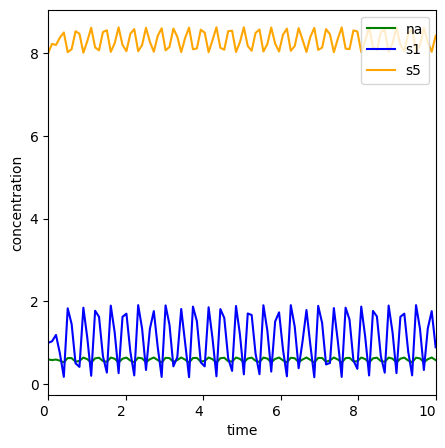

In [6]:
selections = ["time", "s1", "s5", "na"]
_ = CTLSB.plotModel(selections=selections)

## Study 1: Control input is glucose (s1)

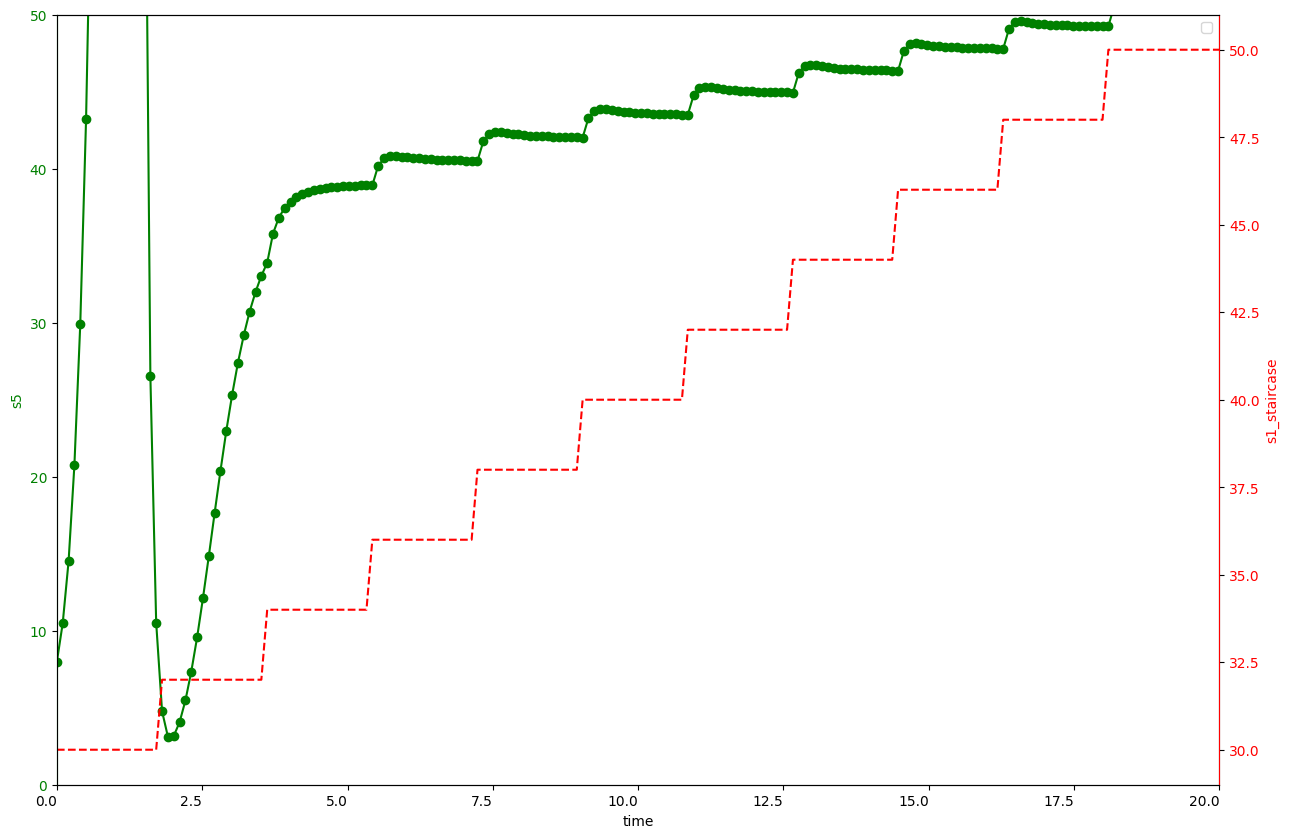

In [7]:
# A controllability analysis using controlSBML
#   The value of the control input is the dashed line in red with the axis on the right
#   The measured output is the green line with the axis on the left
# Control SBML allows for specifying the initial value of the measured input, its final value, and number of steps
_ = CTLSB.plotStaircaseResponse(initial_value=30, final_value=50, num_step=10,
                            times=np.linspace(0, 20, 200), ylim=[0, 50], figsize=(15,10))

There is an initial transient that we ignore.

**Assesment of controllability for Glucose**
1. Increasing $u(t)$ has a monotone effect on $y(t)$ in that either
    * $y(t)$ always increases
    * $y(t)$ always decreases
1. The *steady state* effect of $u(t)$ on $y(t)$ is approximately linear $$(y(\infty) - y(0)) \approx a (u(\infty) - u(0)),$$ $a \in [1, 1.2]$.
1. Transients are short. That is, if $u(t) = u_0$ for $t \leq t_0$ and $u(t) = u_1$ for $t > t_1$,
then $u(t_{ss}) \approx u_1$ for $t_{ss} - t_1$ very small.

Controllability analysis includes a specification of the operating region:
* Range of values of the measured output for which controllability has been established
* Range of the control input used to obtain the values of measured outputs

## Study 2: Control input is NAD (na)

Can other species be used as the control input? How about NAD (``na``)?

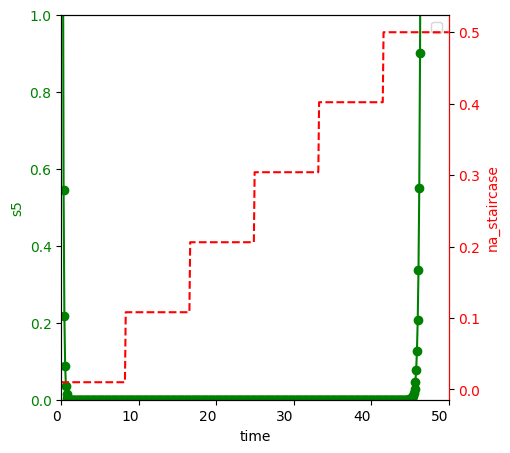

In [8]:
ctlsb = ctl.ControlSBML(URL, input_name="na", output_name="s5")
_ = ctlsb.plotStaircaseResponse(initial_value=.01, final_value=0.5,
                            times=np.linspace(0, 50, 500), ylim=[0, 1])

**Assesment of controllability for Glucose**
1. Increasing $u(t)$ has a monotone effect on $y(t)$ in that either
    * $y(t)$ always increases
    * $y(t)$ always decreases
1. The *steady state* effect of $u(t)$ on $y(t)$ is approximately linear $$(y(\infty) - y(0)) \approx a (u(\infty) - u(0))$$
1. Transients are short. That is, if $u(t) = u_0$ for $t \leq t_0$ and $u(t) = u_1$ for $t > t_1$,
then $u(t_{ss}) \approx u_1$ for $t_{ss} - t_1$ very small.

Controllability analysis includes a specification of the operating region:
* Range of values of the measured output for which controllability has been established
* Range of the control input used to obtain the values of measured outputs